# [Travel Insurance Dataset](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data)

## Can I predict if customers will buy travel insurance?

For this project I use the [Travel Insurance Dataset](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data) to generate supervised machine learning models (i.e. classification models) in order to predict whether a customer will purchase travel insurance.

My goals are as follows:

- Get to know the dataset -- i.e. perform exploratory data analysis (EDA)
- Assess the data quality and perform data wrangling
- Plot the data informatively
- Create various statistical and machine learning models to better understand the dataset (e.g. understand the probability of purchasing travel insurance using a logistic regression model) given the features in the data
- Use these informative models as a baseline by which to compare various classification models
- Tune hyperparameters of effective models in hopes of optimizing our performance and finding the best model available
- Test the optimized classification model

Altogether, these aims should allow us to predict whether someone is likely to purchase travel insurance given our model and to better understand the relationships between the features in these data and purchasing travel insurance.


**module and package imports**


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import shapiro
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    precision_recall_curve,
)
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import statsmodels.api as sm

from utils.modeling import model_assessment_series, model_assessment_series_cv
from utils.plot import (
    plot_numeric_feature_boxplot,
    plot_numerical_features_pairgrid,
    plot_feature_qq_plot,
    plot_correlation_matrix,
    plot_counts_of_categorical_features,
    plot_distribution_of_feature,
    plot_proportion_diff_permutation,
    plot_numerical_column_two_groups_histogram,
)
from utils.stat import (
    calculate_proportion,
    bootstrap_confidence_interval_two_proportions,
    proportion_diff_permutation,
    bootstrap_confidence_interval_two_means,
    mean_diff_permutation,
)

**import data**

_note: Make sure TravelInsurancePrediction.csv is available on the current path by modifying the variable named path_


In [2]:
path = "TravelInsurancePrediction.csv"
travel_insurance_df = pd.read_csv(path, index_col=0)
travel_insurance_df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


## Exploratory Data Analysis (EDA)


In [3]:
travel_insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 155.2+ KB


In [4]:
travel_insurance_df.isnull().any()

Age                    False
Employment Type        False
GraduateOrNot          False
AnnualIncome           False
FamilyMembers          False
ChronicDiseases        False
FrequentFlyer          False
EverTravelledAbroad    False
TravelInsurance        False
dtype: bool

<u>Interim Summary</u>

- There to not appear to be any easily detectable missing rows nor missing values

One thing I would like to do at this early stage of data wrangling is to make my data types more specific.<br><br>
I have several options at this stage regarding how to treat binary (e.g. {0,1}) variables that are "int64" types and strings that are "object" type variables. However, as a general rule-of-thumb I prefer to convert these to "categorical" type variables as a starting point as this works cell for many downstream analyses.


In [5]:
travel_insurance_df.dtypes

Age                     int64
Employment Type        object
GraduateOrNot          object
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance         int64
dtype: object

In [6]:
travel_insurance_df[
    [
        "Employment Type",
        "GraduateOrNot",
        "ChronicDiseases",
        "FrequentFlyer",
        "EverTravelledAbroad",
        "TravelInsurance",
    ]
] = travel_insurance_df[
    [
        "Employment Type",
        "GraduateOrNot",
        "ChronicDiseases",
        "FrequentFlyer",
        "EverTravelledAbroad",
        "TravelInsurance",
    ]
].astype(
    "category"
)

In [7]:
travel_insurance_df.dtypes

Age                       int64
Employment Type        category
GraduateOrNot          category
AnnualIncome              int64
FamilyMembers             int64
ChronicDiseases        category
FrequentFlyer          category
EverTravelledAbroad    category
TravelInsurance        category
dtype: object

---

### Numerical Features


In [8]:
travel_insurance_numerical_df = travel_insurance_df.select_dtypes(include=np.number)
travel_insurance_numerical_df.describe().apply(lambda s: s.apply("{:,.2f}".format))

,Age,AnnualIncome,FamilyMembers
count,"1,987.00","1,987.00","1,987.00"
mean,29.65,"932,762.96",4.75
std,2.91,"376,855.68",1.61
min,25.00,"300,000.00",2.00
25%,28.00,"600,000.00",4.00
50%,29.00,"900,000.00",5.00
75%,32.00,"1,250,000.00",6.00
max,35.00,"1,800,000.00",9.00


<u>Interim Summary</u>

- none of the customers in this dataset are outside the age range 25 to 35

Although this is a mock dataset, I believe that AnnualIncome is off by one order of magnitude, so for the sake of completeness, let's pretend that I talked to my colleagues and that this is true.


In [9]:
travel_insurance_numerical_df["AnnualIncome"] = (
    travel_insurance_numerical_df["AnnualIncome"] / 10
)
travel_insurance_df["AnnualIncome"] = travel_insurance_numerical_df["AnnualIncome"]

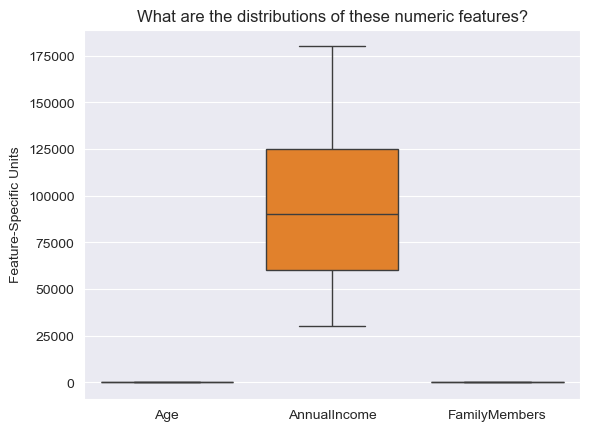

<Axes: title={'center': 'What are the distributions of these numeric features?'}, ylabel='Feature-Specific Units'>

In [10]:
plot_numeric_feature_boxplot(
    travel_insurance_numerical_df,
    y_label="Feature-Specific Units",
    title="What are the distributions of these numeric features?",
)

It is difficult to compare these features without first normalizing them. So I will normalize these features between -1 and +1 to look for outliers.


In [11]:
scaler = StandardScaler()
scaled_travel_ins_num_df = pd.DataFrame(
    scaler.fit_transform(travel_insurance_numerical_df)
)
col_names = travel_insurance_numerical_df.columns
scaled_travel_ins_num_df.columns = col_names

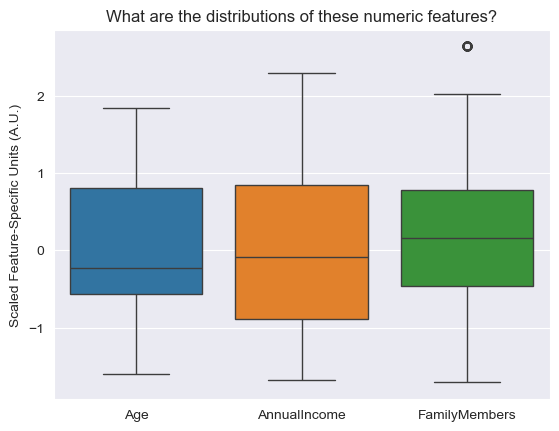

<Axes: title={'center': 'What are the distributions of these numeric features?'}, ylabel='Scaled Feature-Specific Units (A.U.)'>

In [12]:
plot_numeric_feature_boxplot(
    scaled_travel_ins_num_df,
    y_label="Scaled Feature-Specific Units (A.U.)",
    title="What are the distributions of these numeric features?",
)

Notice that FamilyMembers has potential outliers, we will further inspect this later in our data analysis.


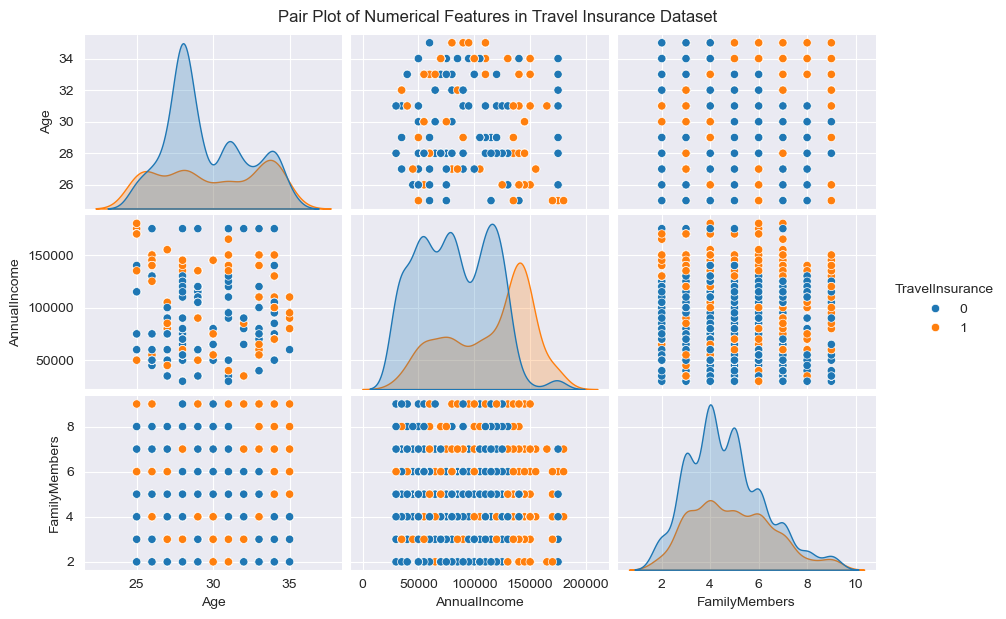

In [13]:
plot_numerical_features_pairgrid(
    travel_insurance_df,
    hue="TravelInsurance",
    height=2,
    aspect=1.5,
    title="Pair Plot of Numerical Features in Travel Insurance Dataset",
)

<u>Interim Summary</u>

- None of these numerical features appear to be normally distributed
- Although numerical, these are all integer features and hence are mostly discrete (e.g. FamilyMembers)

I will further assess whether these features are normally distributed, then I will further assess how these features correlate with one another.


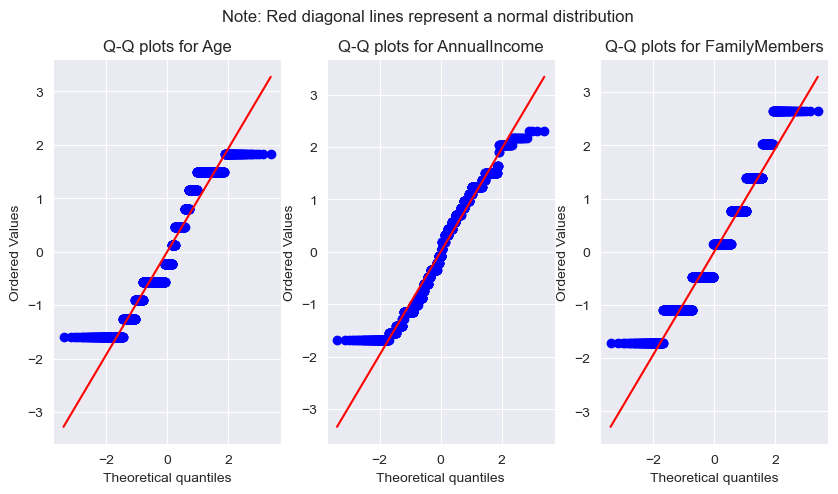

In [14]:
fig, ax = plot_feature_qq_plot(scaled_travel_ins_num_df)

These Q-Q plots further show that these data are not normally distributed. Furthermore, all of these features contain large tails as evidenced by deviations from the diagonal line. Age and FamilyMembers are discrete, yet I will choose to treat them as numeric quantities.


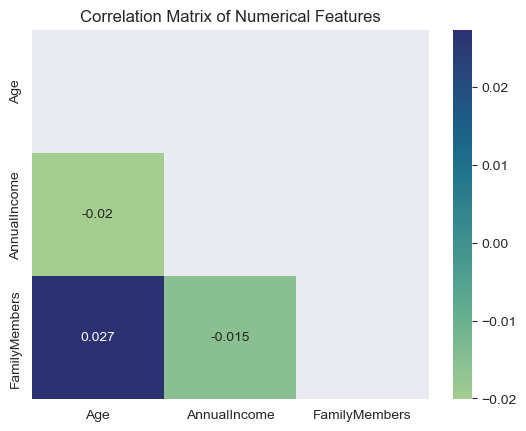

In [15]:
corr_mat_travel_ins_numerical = travel_insurance_numerical_df.corr()
ax = plot_correlation_matrix(
    corr_mat_travel_ins_numerical, title="Correlation Matrix of Numerical Features"
)

None of these features exhibit a particularly strong correlation with one another <br><br>

---

### Categorical Features


In [16]:
travel_insurance_categorical_df = travel_insurance_df.select_dtypes(include="category")
travel_insurance_categorical_df.describe()

,Employment Type,GraduateOrNot,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
count,1987,1987,1987,1987,1987,1987
unique,2,2,2,2,2,2
top,Private Sector/Self Employed,Yes,0,No,No,0
freq,1417,1692,1435,1570,1607,1277


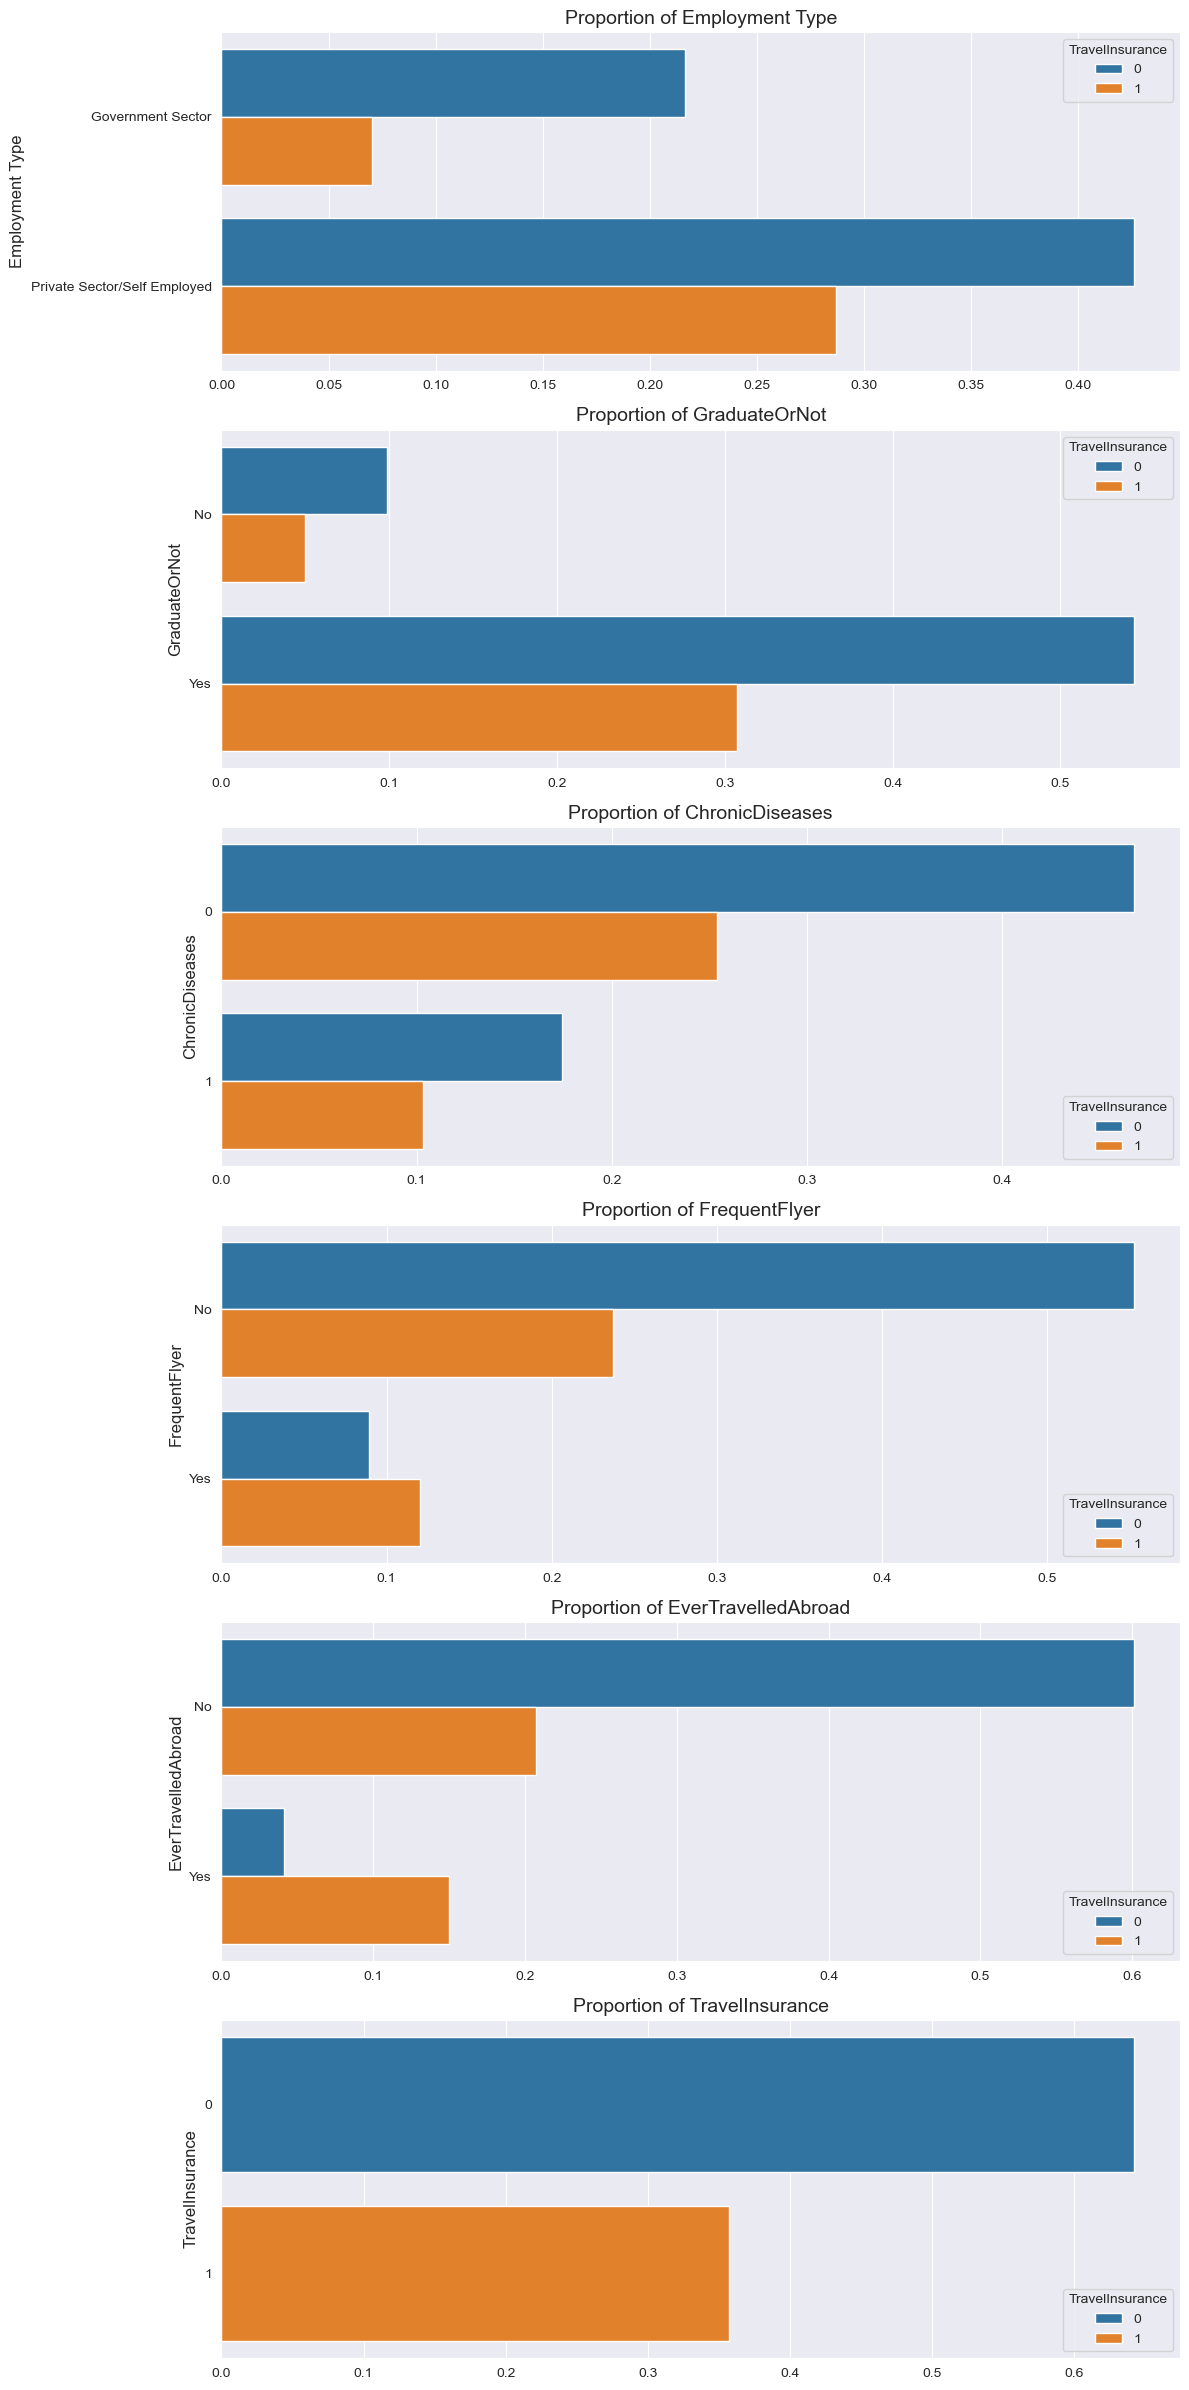

In [17]:
fig, axs = plot_counts_of_categorical_features(
    travel_insurance_categorical_df, stat="probability"
)

<u>Interim Summary</u>
The plots seen above provide us a few pieces of useful information:

- Every one of the categorical variables in this dataset is binary
- Many of these binary categorical variables (e.g. EvertravelledAbroad, FrequentFlyer) can be useful for deciding whether or not someone buys travel insurance
- More people do not buy travel insurance than do buy travel insurance.


## Hypothesis Testing

---

Recall that when we observed family sizes, this observation contained potential outliers when looking at the scale of the data as a whole. Let us inspect this further in order to ask if they are informative. <br><br>i.e. Are large families more likely to purchase travel insurance?

First, let us define a "large" family.


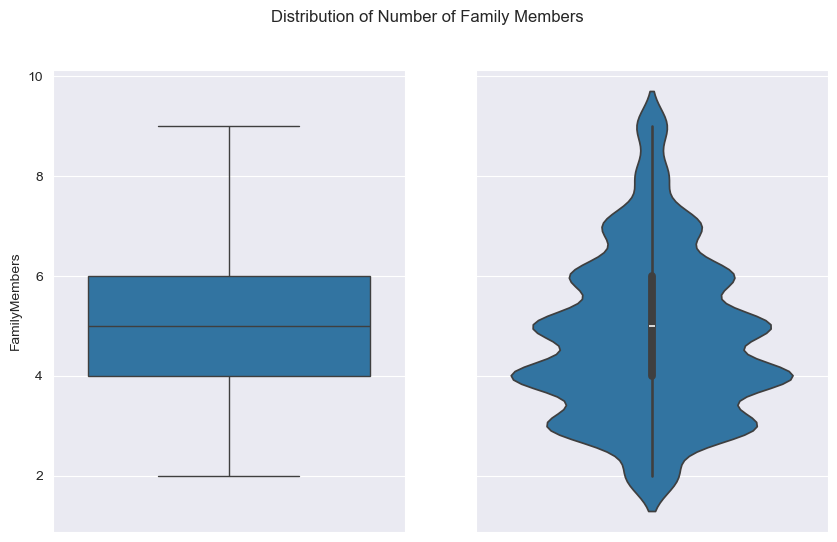

In [18]:
fig, ax1, ax2 = plot_distribution_of_feature(
    travel_insurance_df["FamilyMembers"],
    title="Distribution of Number of Family Members",
)

Based on this distribution of the number of Family Members, I will compare those at the high whiskers of the boxplot (FamilyMembers>6) to those with less than that (FamilyMembers<=6)


**Hypothesis test -- Do large families buy more travel insurance?**
<br><br>
Population_1: 25-35 year olds with large families (> 6 members) who buy tickets to travel <br><br>
Population_2: 25-35 year olds who don't have large families (<= 6 members) who buy tickets to travel <br><br>
$H_0$: Population_1 buys same amount of travel insurance as Population_2 <br><br>
$H_a$: Population_1 buys a different amount of travel insurance as Population_2
<br><br>
significance level, $\alpha$ = 0.05


In [19]:
sample_1 = travel_insurance_df[travel_insurance_df["FamilyMembers"] > 6]
sample_1_proportion = calculate_proportion(sample_1, "TravelInsurance")

sample_2 = travel_insurance_df[travel_insurance_df["FamilyMembers"] <= 6]
sample_2_proportion = calculate_proportion(sample_2, "TravelInsurance")

print(
    f"Proportion of Large Families Buying Travel Insurance: {round(sample_1_proportion,3)}"
)
print(
    f"Proportion of Families with 6 or Less Members Buying Travel Insurance: {round(sample_2_proportion, 3)}"
)

Proportion of Large Families Buying Travel Insurance: 0.438
Proportion of Families with 6 or Less Members Buying Travel Insurance: 0.343


_Now we have a clear statistical question, is this .438 statistically different from this 0.343?_


In [20]:
print(f"Number of Large Families: {len(sample_1)}")
print(f"Number of Families with 6 or Less Members: {len(sample_2)}")

Number of Large Families: 292
Number of Families with 6 or Less Members: 1695


There are multiple ways to approach this problem, one approach would be to invoke the central limit theorem and assume a normal distribution due to the law of large numbers and the sample sizes.

However, we have seen earlier that these data are actually discrete and the normal distribution is a continuous distribution.

So we will use a permutation based approach to see if this difference in proportions is significant.


In [21]:
best_estimate_family_proportion_diffs = sample_1_proportion - sample_2_proportion
print(
    f"{best_estimate_family_proportion_diffs*100:.2f}% More People with Greater than 6 Family Members Buy Travel Insurance. Is this point estimate a good one?"
)

9.50% More People with Greater than 6 Family Members Buy Travel Insurance. Is this point estimate a good one?


First I will calculate a 95% bootstrapped confidence interval to assess the range of values where the population difference (population_1 - population_2) would fall 95% of the time if we used the same method:


In [22]:
lower_bound, upper_bound = bootstrap_confidence_interval_two_proportions(
    sample_1["TravelInsurance"].values,
    sample_2["TravelInsurance"].values,
    alpha=0.05,
    n_iterations=1000,
)

print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

95% Confidence Interval: (0.03, 0.15)


This confidence interval gets close to 0 (no difference), but does not cross 0. This provides some evidence that perhaps a higher proportion of large families buy travel insurance.

How likely is this difference due to chance?

Note: Originally we were just asking about the difference: $H_a$ was that the large families buy a different amount of travel insurance than smaller families. Now I am doing to adjust this hypothesis to be directional on the information I've collected so far. <br><br>

$H_0$: Large Families buys same amount of travel insurance or less travel insurance than Smaller Families <br><br>
$H_a$: Large Families buys a MORE travel insurance than Smaller Families
<br><br>
significance level, $\alpha$ = 0.05


In [23]:
n_permutations = 10000

permutation_difference_null_distribution = [
    100
    * proportion_diff_permutation(
        travel_insurance_df["TravelInsurance"],
        n_obs_a=len(sample_1),
        n_obs_b=len(sample_2),
    )
    for _ in range(n_permutations)
]

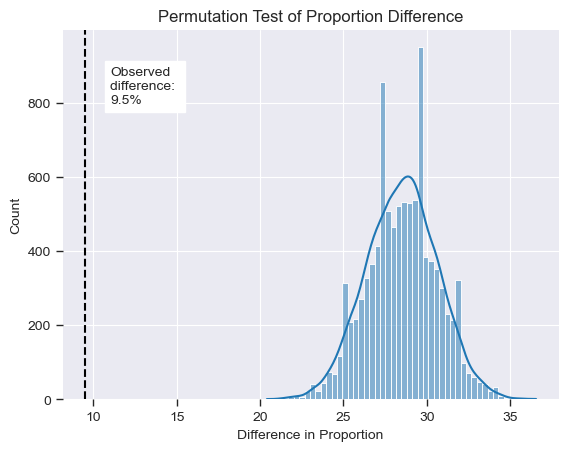

In [24]:
ax = plot_proportion_diff_permutation(
    null_distribution=permutation_difference_null_distribution,
    best_estimate=best_estimate_family_proportion_diffs,
)

In [25]:
observed_difference_pct = best_estimate_family_proportion_diffs * 100
p_value_one_tailed_greater = (
    np.sum(permutation_difference_null_distribution >= observed_difference_pct)
    / n_permutations
)

print(
    f"p-Value for a 1-tailed test that the observed difference in Travel Insurance purchases is greater than the chance null distribution: {p_value_one_tailed_greater:.4f}"
)

p-Value for a 1-tailed test that the observed difference in Travel Insurance purchases is greater than the chance null distribution: 1.0000


As it turns out, there are significantly fewer people with large families that are purchasing travel insurance than would be expected due to a null distribution created from resampling the data at random.

Taken with the information gained from the 95% confidence interval being above 0, we can assume that it is likely that the real population difference is one where more large families buy travel insurance.

My interpretation of these data is that is suggestive of an untapped market wherein large families could in fact purchase MORE travel insurance than what we're observing even though we are observing them buying more than smaller families in our dataset.


---

**Hypothesis test -- Is there is a difference in the mean age of someone likely to purchase travel insurance?**
<br><br>
Population_1: 25-35 year olds who buy travel insurance <br><br>
Population_2: 25-35 year olds who don't buy travel insurance <br><br>
$H_0$: Population_1 has the same mean age as Population_2 <br><br>
$H_a$: Population_1 has a difference mean age than Population_2
<br><br>
significance level, $\alpha$ = 0.05


In [26]:
age_no_ins = travel_insurance_df[["TravelInsurance", "Age"]][
    travel_insurance_df["TravelInsurance"] == 0
]
age_ins = travel_insurance_df[["TravelInsurance", "Age"]][
    travel_insurance_df["TravelInsurance"] == 1
]

Are these ages normally distributed? -- I can assess this with a Shapiro-Wilk test that tests the null hypothesis that the data come from a normal distribution


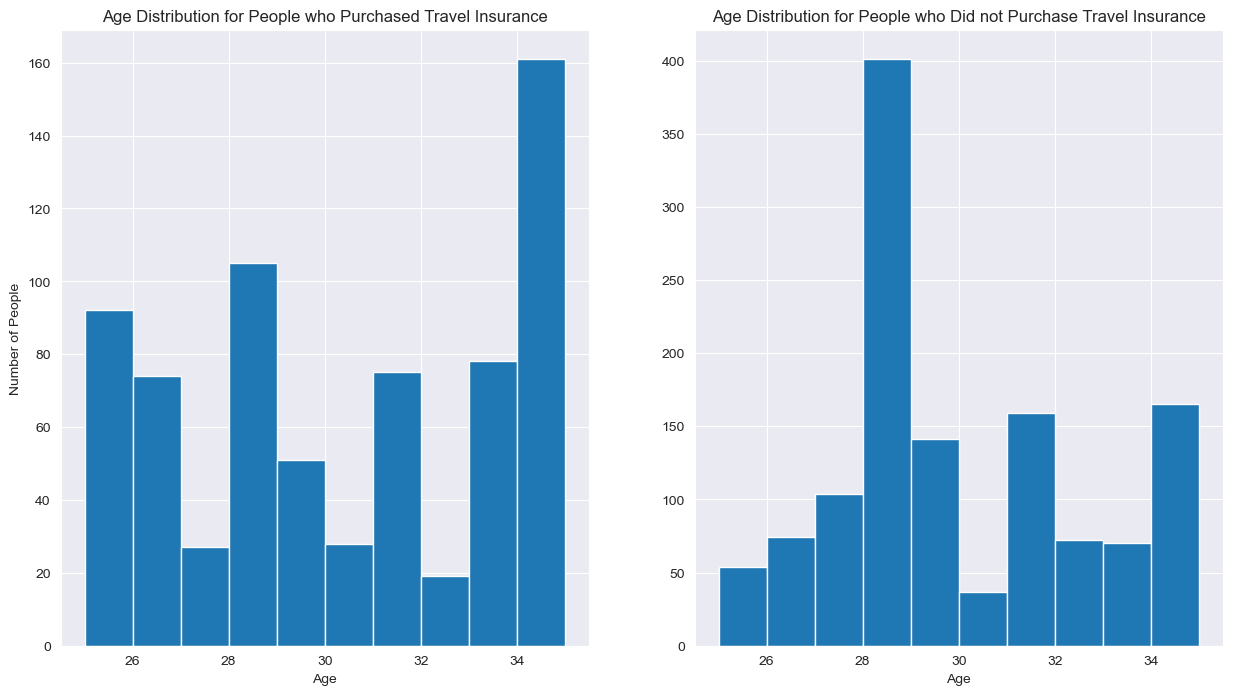

In [27]:
fig, ax1, ax2 = plot_numerical_column_two_groups_histogram(
    age_ins,
    age_no_ins,
    "Age",
    title_group1="Age Distribution for People who Purchased Travel Insurance",
    title_group2="Age Distribution for People who Did not Purchase Travel Insurance",
    x_label="Age",
    y_label="Number of People",
)

In [28]:
_, p = shapiro(age_no_ins["Age"])
print(
    "p-value against null hypothesis that the ages of people who do not get travel insurance are normally distributed %.25f"
    % p
)
_, p = shapiro(age_ins["Age"])
print(
    "p-value against the null hypothesis that the ages of people who get travel insurance are normally distributed %.25f"
    % p
)

p-value against null hypothesis that the ages of people who do not get travel insurance are normally distributed 0.0000000000000000000000002
p-value against the null hypothesis that the ages of people who get travel insurance are normally distributed 0.0000000000000000000076603


Neither of these distributions are likely to be normally distributed. Hence, we are better off continuing to use resampling procedures.


In [29]:
median_age_ins = age_ins["Age"].median()
mean_age_ins = age_ins["Age"].mean()
median_age_no_ins = age_no_ins["Age"].median()
mean_age_no_ins = age_no_ins["Age"].mean()

results = []
for nrepeat in range(1000):
    sample = resample(age_ins["Age"])
    results.append(sample.median())
results = pd.Series(results)
print("Bootstrap Statistics:")
print(f"median age of people who get insurance: {median_age_ins}")
print(f"mean age of people who get insurance: {mean_age_ins:.3f}")
print(f"bias: {(results.mean() - median_age_ins):.3f}")
print(f"std. error: {results.std():.3f}\n\n")

results = []
for nrepeat in range(1000):
    sample = resample(age_no_ins["Age"])
    results.append(sample.median())
results = pd.Series(results)
print("Bootstrap Statistics:")
print(f"median age of people who don't get insurance: {median_age_no_ins}")
print(f"mean age of people who don't get insurance: {mean_age_no_ins:.3f}")
print(f"bias: {(results.mean() - median_age_no_ins):.3f}")
print(f"std. error: {results.std():.3f}")

Bootstrap Statistics:
median age of people who get insurance: 30.0
mean age of people who get insurance: 29.889
bias: -0.274
std. error: 0.543


Bootstrap Statistics:
median age of people who don't get insurance: 29.0
mean age of people who don't get insurance: 29.518
bias: -0.360
std. error: 0.480


Summarizing bootstrapped distributions does not suggest that these are group differences between these populations of ages, but for the sake of completeness, let's test the hypothesis further.


In [30]:
lower_bound, upper_bound = bootstrap_confidence_interval_two_means(
    age_ins["Age"], age_no_ins["Age"], alpha=0.05, n_bootstrap=1000
)
print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

95% Confidence Interval: (0.09, 0.66)


This confidence interval suggests that those who buy travel insurance might be older than those who don't. While this difference is non-zero, it is not stark enough to be something to chase after, but for completeness let's finish our hypothesis testing process.


In [31]:
mean_age_perm_diffs_null_distribution = [
    mean_diff_permutation(travel_insurance_df["Age"], len(age_ins), len(age_no_ins))
    for _ in range(1000)
]

In [32]:
best_estimate_of_mean_age_differences = age_ins["Age"].mean() - age_no_ins["Age"].mean()

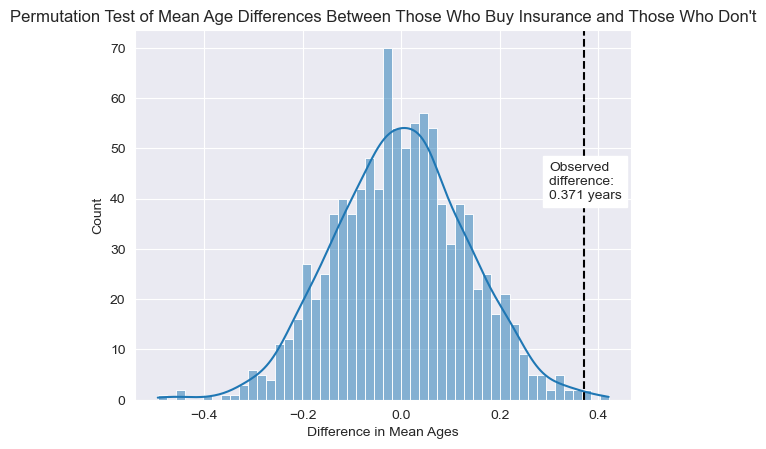

In [33]:
ax = sns.histplot(mean_age_perm_diffs_null_distribution, bins=50, kde=True)
ax.axvline(x=best_estimate_of_mean_age_differences, color="k", linestyle="--")
ax.text(
    0.3,
    40,
    f"Observed\ndifference: \n{best_estimate_of_mean_age_differences:.3f} years",
    bbox={"facecolor": "white"},
)
plt.title(
    "Permutation Test of Mean Age Differences Between Those Who Buy Insurance and Those Who Don't"
)
plt.xlabel("Difference in Mean Ages")
plt.ylabel("Count")
plt.show()

In [34]:
p_value = np.mean(
    [
        diff > best_estimate_of_mean_age_differences
        for diff in mean_age_perm_diffs_null_distribution
    ]
)
print(
    f"""
According to this permutation test the difference in the means 
that we observed would be observed due to chance {p_value*100:.2f}% of the time, p = {p_value}.
"""
)


According to this permutation test the difference in the means 
that we observed would be observed due to chance 0.30% of the time, p = 0.003.



Interestingly, the difference in ages that we are observing is statistically significant, but it is unclear whether this slight difference of less than a year carries any practical significance. <br><br>It would be more informative if this data had a larger range of ages. However, our data is limited to a 10-year range between 25 and 35 years old.


---

**Hypothesis test -- Is there is a difference in the annual income of someone likely to purchase travel insurance?**
<br><br>
Population_1: 25-35 year olds who buy travel insurance <br><br>
Population_2: 25-35 year olds who don't buy travel insurance <br><br>
$H_0$: Population_1 has the same mean annual income as Population_2 <br><br>
$H_a$: Population_1 has a difference mean annual income than Population_2
<br><br>
significance level, $\alpha$ = 0.05


In [35]:
income_no_ins = travel_insurance_df[["TravelInsurance", "AnnualIncome"]][
    travel_insurance_df["TravelInsurance"] == 0
]
income_ins = travel_insurance_df[["TravelInsurance", "AnnualIncome"]][
    travel_insurance_df["TravelInsurance"] == 1
]

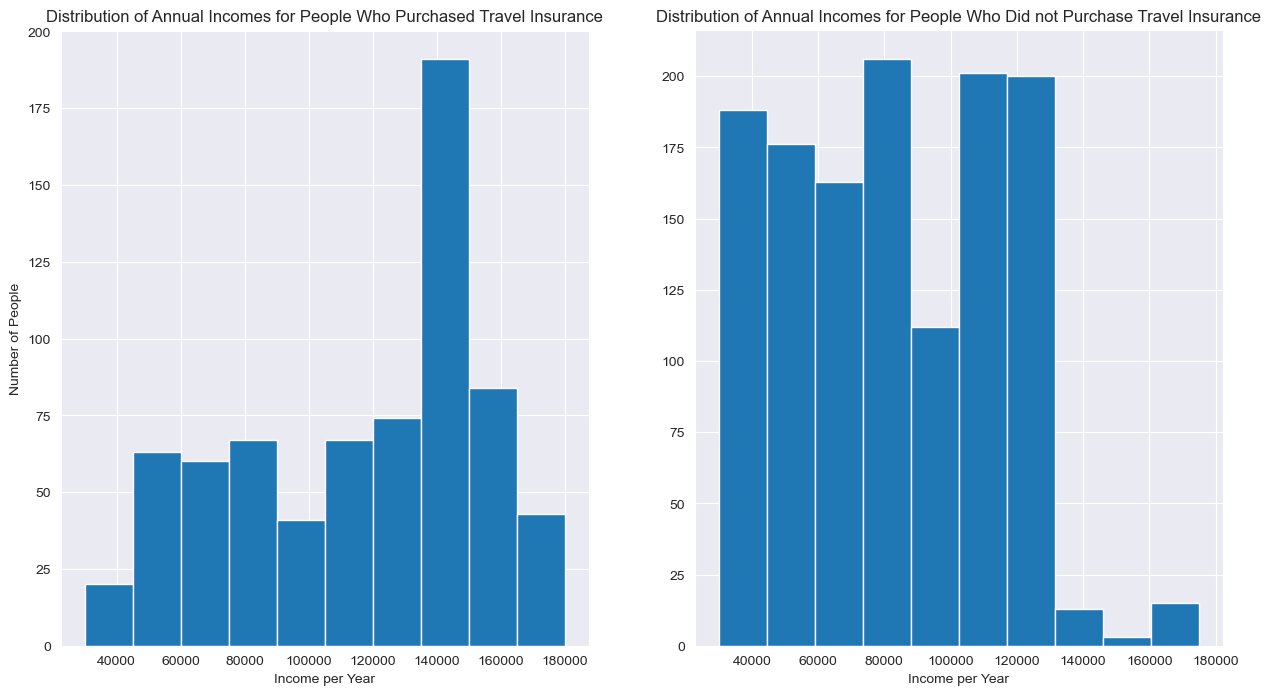

In [36]:
fig, ax1, ax2 = plot_numerical_column_two_groups_histogram(
    income_ins,
    income_no_ins,
    "AnnualIncome",
    title_group1="Distribution of Annual Incomes for People Who Purchased Travel Insurance",
    title_group2="Distribution of Annual Incomes for People Who Did not Purchase Travel Insurance",
    x_label="Income per Year",
    y_label="Number of People",
)

In [37]:
_, p = shapiro(income_no_ins["AnnualIncome"])
print(
    "p-value against null hypothesis that the annual income of people who do not get travel insurance are normally distributed %.25f"
    % p
)
_, p = shapiro(income_ins["AnnualIncome"])
print(
    "p-value against the null hypothesis that the annual income of people who get travel insurance are normally distributed %.25f"
    % p
)

p-value against null hypothesis that the annual income of people who do not get travel insurance are normally distributed 0.0000000000000000008070965
p-value against the null hypothesis that the annual income of people who get travel insurance are normally distributed 0.0000000000000000030383820


Based on these data neither annual incomes are normally distributed, so I will continue to use permutation based approaches.


In [38]:
median_income_ins = income_ins["AnnualIncome"].median()
mean_income_ins = income_ins["AnnualIncome"].mean()
median_income_no_ins = income_no_ins["AnnualIncome"].median()
mean_income_no_ins = income_no_ins["AnnualIncome"].mean()

results = []
for nrepeat in range(1000):
    sample = resample(income_ins["AnnualIncome"])
    results.append(sample.median())
results = pd.Series(results)
print("Bootstrap Statistics:")
print(f"median annual income of people who get insurance: {median_income_ins}")
print(f"mean annual income of people who get insurance: {mean_income_ins:.3f}")
print(f"bias: {(results.mean() - median_income_ins):.3f}")
print(f"std. error: {results.std():.3f}\n\n")

results = []
for nrepeat in range(1000):
    sample = resample(income_no_ins["AnnualIncome"])
    results.append(sample.median())
results = pd.Series(results)
print("Bootstrap Statistics:")
print(f"median annual income of people who don't get insurance: {median_income_no_ins}")
print(f"mean annual income of people who don't get insurance: {mean_income_no_ins:.3f}")
print(f"bias: {(results.mean() - median_income_no_ins):.3f}")
print(f"std. error: {results.std():.3f}")

Bootstrap Statistics:
median annual income of people who get insurance: 125000.0
mean annual income of people who get insurance: 113323.944
bias: 1357.500
std. error: 3708.395


Bootstrap Statistics:
median annual income of people who don't get insurance: 80000.0
mean annual income of people who don't get insurance: 82129.992
bias: -5.000
std. error: 158.114


This is already appears to be informative as the population distributions for those who do and don't purchase insurance hints that those who purchase travel insurance are individuals with a higher annual income distribution.


In [39]:
lower_bound, upper_bound = bootstrap_confidence_interval_two_means(
    income_ins["AnnualIncome"],
    income_no_ins["AnnualIncome"],
    alpha=0.05,
    n_bootstrap=1000,
)
print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

95% Confidence Interval: (27806.15, 34259.78)


There is a noteable difference within the 95% confidence interval on the order of hundreds of thousands of dollars based on these data.


In [40]:
mean_income_perm_diffs_null_distribution = [
    mean_diff_permutation(
        travel_insurance_df["AnnualIncome"], len(income_ins), len(income_no_ins)
    )
    for _ in range(1000)
]

In [41]:
best_estimate_of_mean_income_differences = (
    income_ins["AnnualIncome"].mean() - income_no_ins["AnnualIncome"].mean()
)

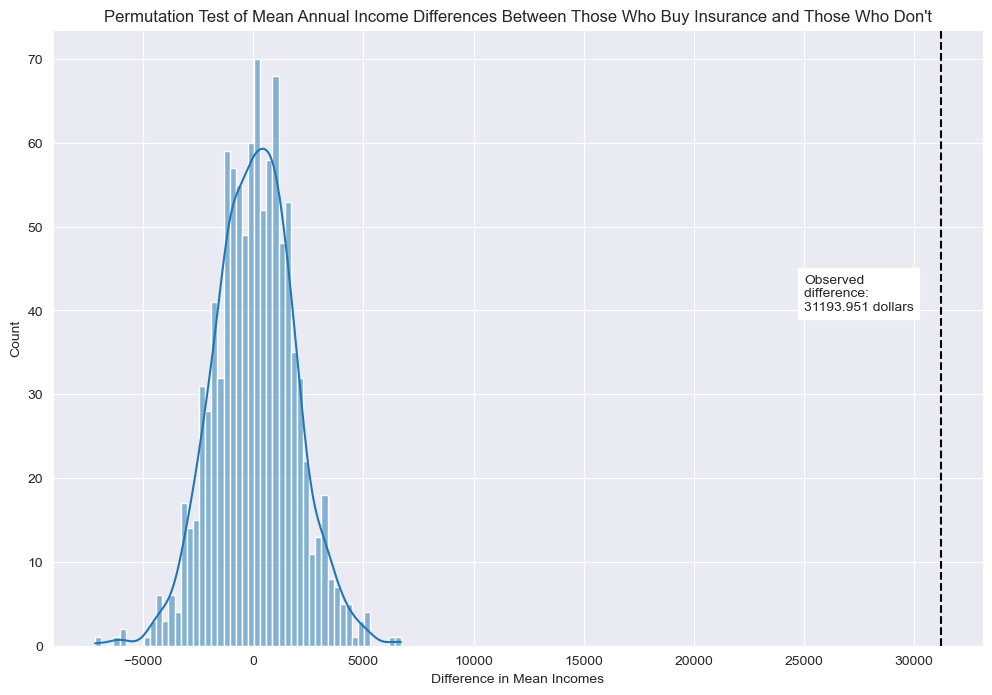

In [42]:
plt.figure(figsize=(12, 8))
ax = sns.histplot(mean_income_perm_diffs_null_distribution, bins=50, kde=True)
ax.axvline(x=best_estimate_of_mean_income_differences, color="k", linestyle="--")
ax.text(
    25000,
    40,
    f"Observed\ndifference: \n{best_estimate_of_mean_income_differences:.3f} dollars",
    bbox={"facecolor": "white"},
)
plt.title(
    "Permutation Test of Mean Annual Income Differences Between Those Who Buy Insurance and Those Who Don't"
)
plt.xlabel("Difference in Mean Incomes")
plt.ylabel("Count")
plt.show()

In [43]:
p_value = np.mean(
    [
        diff > best_estimate_of_mean_income_differences
        for diff in mean_income_perm_diffs_null_distribution
    ]
)
print(
    f"""
According to this permutation test the difference in the means 
that we observed would be observed due to chance {p_value*100}% of the time, p = {p_value} (i.e. p<0.05).
"""
)


According to this permutation test the difference in the means 
that we observed would be observed due to chance 0.0% of the time, p = 0.0 (i.e. p<0.05).



According to these data it seems that those who purchase travel insurance are wealthier customers who earn over 100k per year.


## Classification Modeling


For the sake of future steps, I will convert the binary categorical variables to 0 and 1 values (i.e. dummy variables).


In [44]:
for col in travel_insurance_categorical_df.columns:
    label_encoder = LabelEncoder()
    encoded = label_encoder.fit_transform(travel_insurance_df[col])
    travel_insurance_df[col] = encoded
travel_insurance_df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,0,1,40000.0,6,1,0,0,0
1,31,1,1,125000.0,7,0,0,0,0
2,34,1,1,50000.0,4,1,0,0,1
3,28,1,1,70000.0,3,1,0,0,0
4,28,1,1,70000.0,8,1,1,0,0


Now, I will split my data into a training set and a testing set.<br><br>

Note: I will occasionally use a hold-out validation set (i.e. when using statsmodels) and at other times I will use a cross-validation approach when possible. <br><br>
Since there are less than 2,000 observations in this entire dataset I will use a k-fold cross validation approach whenever it is readily available in order to retain the maximal number of observations in my testing data.

I will first split my data:

- 80% for Training (and cross-validation)
- 20% for Testing <br>

Then from the 80% from training:

- 80% for training
- 20% for validation

So in the end we have:

- 20% of data strictly for testing
- 16% of the data as a hold-out validation set
- 64% of the data exclusively for training


In [45]:
X = travel_insurance_df.drop(["TravelInsurance"], axis=1)
y = travel_insurance_df["TravelInsurance"]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_subset, X_valid, y_train_subset, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0
)

The approach I will take is as follows:<br><br>

- First, I will try out each model that I intend to use in order to gain insight about relationships in the data and in order to select the models that work best on their face.
- Then, I will use a GridSearch approach with the to models in order to tune hyperparameters.
- Finally, I will develop a voting model with the highest performing models as the final model for deployment.


**Model 1a: Logistic Regression with Statsmodels**


In [47]:
X_sm = sm.add_constant(X_train_subset)

log_reg_sm_model = sm.GLM(y_train_subset, X_sm, family=sm.families.Binomial())
log_reg_sm_results = log_reg_sm_model.fit()
log_reg_sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        TravelInsurance   No. Observations:                 1271
Model:                            GLM   Df Residuals:                     1262
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -670.17
Date:                Sun, 23 Jun 2024   Deviance:                       1340.3
Time:                        17:13:35   Pearson chi2:                 1.29e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2274
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.3378      0.779     -6.851      0.000      -6.865      -3.811
Age                     0.0721      0.023      3.162      0.002       0.027       0.117
Employment Type         0.2765      0.166      1.666      0.096      -0.049       0.602
GraduateOrNot          -0.1374      0.192     -0.717      0.474      -0.513       0.238
AnnualIncome         1.306e-05    2.2e-06      5.944      0.000    8.75e-06    1.74e-05
FamilyMembers           0.1702      0.042      4.076      0.000       0.088       0.252
ChronicDiseases         0.0811      0.150      0.542      0.588      -0.212       0.374
FrequentFlyer           0.5258      0.175      3.007      0.003       0.183       0.869
EverTravelledAbroad     1.7688      0.191      9.274      0.000       1.395       2.143
=======================================================================================
"""

This model suggests a few things:

- important features that predict TravelInsurance include: EverTravelledAbroad, FamilyMembers, AnnualIncome, Age, and Frequent Flyer
- particularly unimportant features include: GraduateOrNot and ChronicDiseases


In [48]:
log_reg_sm_params = log_reg_sm_results.params
log_reg_sm_odds = np.exp(log_reg_sm_results.params)
log_reg_sm_pvalues = log_reg_sm_results.pvalues
log_reg_sm_percent = (log_reg_sm_odds - 1) * 100

In [49]:
log_reg_sm_results_table = pd.concat(
    [
        log_reg_sm_params,
        round(log_reg_sm_pvalues, 8),
        log_reg_sm_odds,
        log_reg_sm_percent,
    ],
    axis=1,
)
log_reg_sm_results_table.rename(
    columns={0: "coefficients", 1: "p-values", 2: "odds", 3: "odds as percent"}
)

,coefficients,p-values,odds,odds as percent
const,-5.337770,0.000000,0.004807,-99.519342
Age,0.072065,0.001564,1.074725,7.472530
Employment Type,0.276456,0.095630,1.318449,31.844901
GraduateOrNot,-0.137412,0.473529,0.871611,-12.838874
AnnualIncome,0.000013,0.000000,1.000013,0.001306
FamilyMembers,0.170153,0.000046,1.185486,18.548607
ChronicDiseases,0.081090,0.587980,1.084468,8.446827
FrequentFlyer,0.525814,0.002642,1.691835,69.183490
EverTravelledAbroad,1.768752,0.000000,5.863534,486.353390


This allows us the most human-understandable interpretation of our features relationship to the outcome. <br>For instance, according to this model, all other things constant, EverTravelledAbroad increases the odds of Travel Insurance by over 486%, FrequentFlyer increases odds by over 69%, Private Sector Employment increases odds of purchases of travel insurance by over 31%. These are valuable insights.

Now I would like to make predictions with this model in order to assess it's quality.


In [50]:
log_reg_sm_train_predictions = np.zeros((len(X_train_subset)))
log_reg_sm_train_probabilities = log_reg_sm_results.predict()
log_reg_sm_train_predictions[log_reg_sm_train_probabilities > 0.5] = 1

In [51]:
log_reg_sm_train_conf_mat = confusion_matrix(
    log_reg_sm_train_predictions, y_train_subset
)
print("confusion matrix\n", log_reg_sm_train_conf_mat)
log_reg_sm_train_assessment = model_assessment_series(
    log_reg_sm_train_predictions, y_train_subset, "logistic reg SM train"
)
log_reg_sm_train_assessment

confusion matrix
 [[745 237]
 [ 62 227]]


Accuracy     0.764752
Precision    0.489224
Recall       0.785467
F1-Score     0.602922
Name: logistic reg SM train, dtype: float64

While these predictions seem okay (at best) for one this is TRAINING accuracy, not VALIDATION or TESTING accuracy.

Now I will do a few things:

- Test a "DummyClassifier", essentially a baseline model to see how the model performs given the same data
- Then I will use the hold-out validation set to compare those stats


In [52]:
dummy_clf_subset = DummyClassifier()
dummy_clf_subset.fit(X_train_subset, y_train_subset)
dummy_clf_subset_accuracy = np.mean(
    cross_val_score(
        dummy_clf_subset, X_train_subset, y_train_subset, cv=5, scoring="accuracy"
    )
)
print(f"Dummy Model Accuracy: {dummy_clf_subset_accuracy}")

Dummy Model Accuracy: 0.6349328392774432


This is the score to beat, and we do in fact beat it, but we could do even better. Moreover, how does this model generalize?


In [53]:
X_valid_exog = sm.add_constant(X_valid)

log_reg_sm_val_predictions = np.zeros((len(X_valid_exog)))
log_reg_sm_val_probabilities = log_reg_sm_results.predict(exog=X_valid_exog)
log_reg_sm_val_predictions[log_reg_sm_val_probabilities > 0.5] = 1

In [54]:
log_reg_sm_val_conf_mat = confusion_matrix(log_reg_sm_val_predictions, y_valid)
print("confusion matrix\n", log_reg_sm_val_conf_mat)
log_reg_sm_val_assessment = model_assessment_series(
    log_reg_sm_val_predictions, y_valid, "logistic reg SM validation"
)
log_reg_sm_val_assessment

confusion matrix
 [[196  56]
 [ 14  52]]


Accuracy     0.779874
Precision    0.481481
Recall       0.787879
F1-Score     0.597701
Name: logistic reg SM validation, dtype: float64

Let's compare the train and validation performance


In [55]:
log_reg_sm_assessment = pd.concat(
    [log_reg_sm_train_assessment, log_reg_sm_val_assessment], axis=1
)
log_reg_sm_assessment

,logistic reg SM train,logistic reg SM validation
Accuracy,0.764752,0.779874
Precision,0.489224,0.481481
Recall,0.785467,0.787879
F1-Score,0.602922,0.597701


the generalizability of this model is quite impressive as the accuracy is better on the validation set and the other metrics that are derived from the confusion matrix stay quite constant. This is also a nice model because of its interpretability.


Next, I will try a Logistic Regression model from Scikit-Learn with minimal intervention to hyperparameters to see how it performs in comparison.

Because for the models moving forward I will be using a cross-validation procedure and not a hold-out set, I will run a dummy classifier on the whole training set in order to set a baseline score to beat:


In [56]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
dummy_clf_accuracy = np.mean(
    cross_val_score(dummy_clf, X_train, y_train, cv=5, scoring="accuracy")
)
print(f"Dummy Model Accuracy: {dummy_clf_accuracy}")

Dummy Model Accuracy: 0.6400253953137709


This is the score to beat with any of our models from this point forward


**Model 1b: Logistic Regression with Scikit-learn**


In [59]:
log_reg_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("log_reg", LogisticRegression(random_state=0, max_iter=1000)),
    ]
)
log_reg_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression(max_iter=1000, random_state=0))])

In [60]:
log_reg_sk_assessment = model_assessment_series_cv(
    log_reg_model, X_train, y_train, cv=10, model_name="logistic regression sklearn"
)
log_reg_sk_assessment

Accuracy     0.765254
Precision    0.787223
Recall       0.482789
F1-Score     0.594455
Name: logistic regression sklearn, dtype: float64

comparing all models to this point:


In [61]:
log_reg_assessment = pd.concat([log_reg_sm_assessment, log_reg_sk_assessment], axis=1)
log_reg_assessment

,logistic reg SM train,logistic reg SM validation,logistic regression sklearn
Accuracy,0.764752,0.779874,0.765254
Precision,0.489224,0.481481,0.787223
Recall,0.785467,0.787879,0.482789
F1-Score,0.602922,0.597701,0.594455


Comparing the model from statsmodels that applies no default regularization to the model from sklearn that applies l2-regularization by default, you can notice the precision-recall tradeoff.


**Model 2a: Linear Discriminant Analysis (LDA)**


In [62]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train, y_train)
LDA_loadings = pd.DataFrame(LDA_model.scalings_, index=X_train.columns)
LDA_loadings

,0
Age,0.058606
Employment Type,0.106826
GraduateOrNot,-0.191336
AnnualIncome,0.000012
FamilyMembers,0.145341
ChronicDiseases,0.048016
FrequentFlyer,0.382615
EverTravelledAbroad,1.901953


The "loadings" or "scalings" seen above are the weight of each feature for the LDA model and can act as a proxy of feature importance. Notice that this essentially corresponds to the same weights as seen with our logistic regression coefficients, EverTravelledAbroad is very explanatory, AnnualIncome isn't so much. This is interesting because AnnualIncome was quite a significant and informative predictor based on our previous hypothesis testing.

Comparing models to this point:


In [63]:
LDA_assessment = model_assessment_series_cv(
    LDA_model, X_train, y_train, cv=10, model_name="LDA"
)
model_assessment = pd.concat([log_reg_assessment, LDA_assessment], axis=1)
model_assessment

,logistic reg SM train,logistic reg SM validation,logistic regression sklearn,LDA
Accuracy,0.764752,0.779874,0.765254,0.758339
Precision,0.489224,0.481481,0.787223,0.795344
Recall,0.785467,0.787879,0.482789,0.449546
F1-Score,0.602922,0.597701,0.594455,0.570198


LDA competes with the logistic regression. However, it does not have as much flexibilty as other models in terms of hyperparameters to tune.


**Model 2b: Quadratic Discriminant Analysis (QDA)**

Now we will make a new assumption, that our data is quadratically related to the outcome.


In [64]:
QDA_model = QuadraticDiscriminantAnalysis()
QDA_model.fit(X_train, y_train)
QDA_assessment = model_assessment_series_cv(
    QDA_model, X_train, y_train, cv=10, model_name="QDA"
)
model_assessment = pd.concat([model_assessment, QDA_assessment], axis=1)
model_assessment

,logistic reg SM train,logistic reg SM validation,logistic regression sklearn,LDA,QDA
Accuracy,0.764752,0.779874,0.765254,0.758339,0.774688
Precision,0.489224,0.481481,0.787223,0.795344,0.770449
Recall,0.785467,0.787879,0.482789,0.449546,0.542226
F1-Score,0.602922,0.597701,0.594455,0.570198,0.632570


Allowing more curvature to decision boundaries appeared to slightly improve the model performance.


**Model 3: K-Nearest Neighbors**

This model is highly flexible and allows for several parameters such as the number of neighbors used for classification to be set. However, I will first just try it straight ouf of the box and see how it performs


In [65]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_assessment = model_assessment_series_cv(
    knn_model, X_train, y_train, cv=10, model_name="knn"
)
model_assessment = pd.concat([model_assessment, knn_assessment], axis=1)
model_assessment

,logistic reg SM train,logistic reg SM validation,logistic regression sklearn,LDA,QDA,knn
Accuracy,0.764752,0.779874,0.765254,0.758339,0.774688,0.821256
Precision,0.489224,0.481481,0.787223,0.795344,0.770449,0.855027
Recall,0.785467,0.787879,0.482789,0.449546,0.542226,0.610284
F1-Score,0.602922,0.597701,0.594455,0.570198,0.632570,0.710353


This is actually remarkable how well k-Nearest Neighbors performs immediately without tuning any hyperparameters. I am able to improve almost every model assessment metric with this strategy.


**Model 4a: Linear Support Vector Machine Classifier**


In [67]:
linear_svc_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", dual="auto", random_state=0)),
    ]
)

linear_svc_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=1, dual='auto', loss='hinge', random_state=0))])

In [68]:
linear_svc_assessment = model_assessment_series_cv(
    linear_svc_model, X_train, y_train, cv=10, model_name="linear svc"
)
model_assessment = pd.concat([model_assessment, linear_svc_assessment], axis=1)
model_assessment

,logistic reg SM train,logistic reg SM validation,logistic regression sklearn,LDA,QDA,knn,linear svc
Accuracy,0.764752,0.779874,0.765254,0.758339,0.774688,0.821256,0.750792
Precision,0.489224,0.481481,0.787223,0.795344,0.770449,0.855027,0.799367
Recall,0.785467,0.787879,0.482789,0.449546,0.542226,0.610284,0.416364
F1-Score,0.602922,0.597701,0.594455,0.570198,0.632570,0.710353,0.543132


So far this is our worst predicting model, providing more evidence that use of linear decision boundaries does not capture the variability in these data.


**Model 4b: Support Vector Machine Classifier with Kernel**


In [69]:
kernel_svc_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("kernel_svc", SVC(kernel="rbf")),
    ]
)

kernel_svc_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('kernel_svc', SVC())])

In [70]:
kernel_svc_assessment = model_assessment_series_cv(
    kernel_svc_model, X_train, y_train, cv=10, model_name="kernel svc"
)
model_assessment = pd.concat([model_assessment, kernel_svc_assessment], axis=1)
model_assessment

,logistic reg SM train,logistic reg SM validation,logistic regression sklearn,LDA,QDA,knn,linear svc,kernel svc
Accuracy,0.764752,0.779874,0.765254,0.758339,0.774688,0.821256,0.750792,0.816229
Precision,0.489224,0.481481,0.787223,0.795344,0.770449,0.855027,0.799367,0.877792
Recall,0.785467,0.787879,0.482789,0.449546,0.542226,0.610284,0.416364,0.573684
F1-Score,0.602922,0.597701,0.594455,0.570198,0.632570,0.710353,0.543132,0.690967


Using a kernel to deal with non-linearity appears to improve the model substantially.


**Model 4c: Support Vector Machine Classifier with Polynomial Kernel**


In [71]:
poly_kernel_svc_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("poly_svc", SVC(kernel="poly", degree=3)),
    ]
)

poly_kernel_svc_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('poly_svc', SVC(kernel='poly'))])

In [72]:
poly_kernel_svc_assessment = model_assessment_series_cv(
    poly_kernel_svc_model, X_train, y_train, cv=10, model_name="poly_kernel svc"
)
model_assessment = pd.concat([model_assessment, poly_kernel_svc_assessment], axis=1)
model_assessment

,logistic reg SM train,logistic reg SM validation,logistic regression sklearn,LDA,QDA,knn,linear svc,kernel svc,poly_kernel svc
Accuracy,0.764752,0.779874,0.765254,0.758339,0.774688,0.821256,0.750792,0.816229,0.795462
Precision,0.489224,0.481481,0.787223,0.795344,0.770449,0.855027,0.799367,0.877792,0.861148
Recall,0.785467,0.787879,0.482789,0.449546,0.542226,0.610284,0.416364,0.573684,0.517665
F1-Score,0.602922,0.597701,0.594455,0.570198,0.632570,0.710353,0.543132,0.690967,0.644384


**Model 5a: Decision Tree Classifier**


In [73]:
decision_tree_model = DecisionTreeClassifier(random_state=0)
decision_tree_model.fit(X_train, y_train)
decision_tree_assessment = model_assessment_series_cv(
    decision_tree_model, X_train, y_train, cv=10, model_name="decision tree"
)
model_assessment = pd.concat([model_assessment, decision_tree_assessment], axis=1)
model_assessment

,logistic reg SM train,logistic reg SM validation,logistic regression sklearn,LDA,QDA,knn,linear svc,kernel svc,poly_kernel svc,decision tree
Accuracy,0.764752,0.779874,0.765254,0.758339,0.774688,0.821256,0.750792,0.816229,0.795462,0.764645
Precision,0.489224,0.481481,0.787223,0.795344,0.770449,0.855027,0.799367,0.877792,0.861148,0.698360
Recall,0.785467,0.787879,0.482789,0.449546,0.542226,0.610284,0.416364,0.573684,0.517665,0.619087
F1-Score,0.602922,0.597701,0.594455,0.570198,0.632570,0.710353,0.543132,0.690967,0.644384,0.654048


One thing it appears that the decision tree does very well is to optimize between the precision-recall tradeoff with its default settings.


**Model 5b: Ensemble Classifier -- Random Forest**


In [74]:
random_forest_model = RandomForestClassifier(random_state=0, n_jobs=-1)
model = random_forest_model.fit(X_train, y_train)
random_forest_assessment = model_assessment_series_cv(
    random_forest_model, X_train, y_train, cv=10, model_name="random forest"
)
model_assessment = pd.concat([model_assessment, random_forest_assessment], axis=1)
model_assessment

,logistic reg SM train,logistic reg SM validation,logistic regression sklearn,LDA,QDA,knn,linear svc,kernel svc,poly_kernel svc,decision tree,random forest
Accuracy,0.764752,0.779874,0.765254,0.758339,0.774688,0.821256,0.750792,0.816229,0.795462,0.764645,0.791693
Precision,0.489224,0.481481,0.787223,0.795344,0.770449,0.855027,0.799367,0.877792,0.861148,0.698360,0.752474
Recall,0.785467,0.787879,0.482789,0.449546,0.542226,0.610284,0.416364,0.573684,0.517665,0.619087,0.631337
F1-Score,0.602922,0.597701,0.594455,0.570198,0.632570,0.710353,0.543132,0.690967,0.644384,0.654048,0.684797


This model appears to be the most computationally expensive so far.


## Hyperparameter Tuning


**model 1: Logistic Regression** <br><br>
Although I believe that the best "out-of-the-box" performance came from statsmodels version of the algorithm. I believe I have more room to tune hyperparameters from scikit-learn.

The first thing I will try to do is to investigate the precision-recall tradeoff to consider optimizing the threshold used for classification.


In [75]:
log_reg_y_scores = cross_val_predict(
    log_reg_model, X_train, y_train, cv=10, method="decision_function"
)
precisions, recalls, thresholds = precision_recall_curve(y_train, log_reg_y_scores)

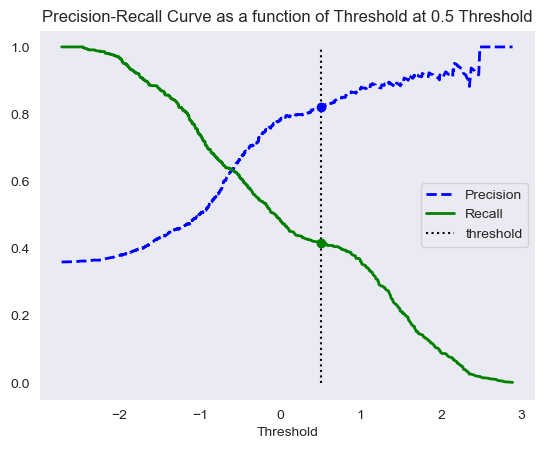

In [81]:
default_threshold = 0.5
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(default_threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= default_threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.title("Precision-Recall Curve as a function of Threshold at 0.5 Threshold")
plt.show()

This visualization assumes that 0.5 is a reasonable threshold value.


At this stage it is important to revisit<br>
_What is the business problem?_<br><br>

Our company wants to _accurately_ predict whether the customer will get travel insurance or not. There is no immediately tangible cost to getting it wrong, but our company wants an accurate model. We intend to use this information for future marketing and customer research.

Although more people don't get travel insurance than those who do, both classes are of equal importance for the sake of our company's knowledge base and this imbalance (approximately 65% no to 35% yes) is sufficient to maximize accuracy without particular emphasis on precision or recall. We want to reach out to as many customers as possible with increased targeted marketing, but first we want to understand who those customers are. <br><br>

So for model selection, let's suggest that we're seeking accuracy over all and balance (F1-score) secondarily. Instead of changing the threshold (which we know we can do in order to meet a business need, such as increasing recall to cast a wider net).

We will keep these business goals in mind as we tune our hyperparameters.


In [85]:
log_reg_params = {
    "log_reg__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "log_reg__penalty": ["l1", "l2"],
    "log_reg__solver": ["liblinear", "saga"],
    "log_reg__max_iter": [100, 200, 300],
    "log_reg__tol": [1e-4, 1e-3, 1e-2],
    "log_reg__class_weight": [None, "balanced"],
}
log_reg_gs = GridSearchCV(
    log_reg_model, param_grid=log_reg_params, cv=5, scoring="accuracy", n_jobs=-1
)
log_reg_gs.fit(X_train, y_train)
log_reg_best_params = log_reg_gs.best_params_

print(f"Best hyperparameters for Logistic Regression: {log_reg_best_params}")

Best hyperparameters for Logistic Regression: {'log_reg__C': 100, 'log_reg__class_weight': None, 'log_reg__max_iter': 100, 'log_reg__penalty': 'l1', 'log_reg__solver': 'saga', 'log_reg__tol': 0.01}


In [87]:
log_reg_model_tuned = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "log_reg",
            LogisticRegression(
                C=100,
                class_weight=None,
                max_iter=100,
                penalty="l1",
                solver="saga",
                tol=0.01,
                random_state=0,
            ),
        ),
    ]
)
log_reg_model_tuned.fit(X_train, y_train)
log_reg_tuned_assessment = model_assessment_series_cv(
    log_reg_model_tuned, X_train, y_train, cv=10, model_name="logistic regression tuned"
)
log_reg_tuned_assessment

Accuracy     0.766511
Precision    0.788704
Recall       0.486237
F1-Score     0.598027
Name: logistic regression tuned, dtype: float64

**model 2: QDA**

When investigating various models it became clear that linear separators do not capture the variance of this data as well as those that allow for curvature. So, I will attempt to optimize QDA instead of LDA.


In [88]:
QDA_params = {"reg_param": [0.0, 0.01, 0.1, 0.5, 1.0], "tol": [1e-5, 1e-4, 1e-3, 1e-2]}
QDA_gs = GridSearchCV(
    QDA_model, param_grid=QDA_params, cv=5, scoring="accuracy", n_jobs=-1
)
QDA_gs.fit(X_train, y_train)
QDA_best_params = QDA_gs.best_params_

print(f"Best hyperparameters for Quadratic Discriminant Analysis: {QDA_best_params}")

Best hyperparameters for Quadratic Discriminant Analysis: {'reg_param': 0.1, 'tol': 1e-05}


In [89]:
QDA_model_tuned = QuadraticDiscriminantAnalysis(reg_param=0.1, tol=1e-05)
QDA_model_tuned.fit(X_train, y_train)
QDA_tuned_assessment = model_assessment_series_cv(
    QDA_model_tuned, X_train, y_train, cv=10, model_name="QDA tuned"
)
QDA_tuned_assessment

Accuracy     0.788528
Precision    0.799468
Recall       0.556201
F1-Score     0.653525
Name: QDA tuned, dtype: float64

**model 3: k-Nearest Neighbors** <br>
This model performed quite well, so let's see what some tuning does for us.


In [94]:
knn_params = {
    "n_neighbors": [3, 5, 7, 10],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": [10, 20, 30],
    "p": [1, 2],
}
knn_gs = GridSearchCV(knn_model, param_grid=knn_params, cv=5, scoring="f1", n_jobs=-1)
knn_gs.fit(X_train, y_train)
knn_best_params = knn_gs.best_params_

print(f"Best hyperparameters for Logistic Regression: {knn_best_params}")

Best hyperparameters for Logistic Regression: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}


from running this a few time I actually noticed that optimizing for F1 in this circumstance actually has better accuracy performance.


In [95]:
knn_model_tuned = KNeighborsClassifier(
    algorithm="auto", leaf_size=20, n_neighbors=7, p=1, weights="uniform"
)
knn_model_tuned.fit(X_train, y_train)
knn_tuned_assessment = model_assessment_series_cv(
    knn_model_tuned, X_train, y_train, cv=10, model_name="KNN tuned"
)
knn_tuned_assessment

Accuracy     0.822514
Precision    0.862901
Recall       0.605203
F1-Score     0.709272
Name: KNN tuned, dtype: float64

**model 4: kernel support vector machine classifier**


In [96]:
kernel_svc_params = {
    "kernel_svc__C": [0.1, 1, 10, 100],
    "kernel_svc__gamma": [0.001, 0.01, 0.1, 1.0],
    "kernel_svc__class_weight": [None, "balanced"],
}

kernel_svc_gs = GridSearchCV(
    kernel_svc_model, param_grid=kernel_svc_params, cv=5, scoring="accuracy", n_jobs=-1
)
kernel_svc_gs.fit(X_train, y_train)
kernel_svc_best_params = kernel_svc_gs.best_params_

print(f"Best hyperparameters for Gaussian RBF Kernel SVC: {kernel_svc_best_params}")

Best hyperparameters for Gaussian RBF Kernel SVC: {'kernel_svc__C': 10, 'kernel_svc__class_weight': None, 'kernel_svc__gamma': 0.1}


In [97]:
kernel_svc_model_tuned = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("kernel_svc", SVC(kernel="rbf", C=10, class_weight=None, gamma=0.1)),
    ]
)

kernel_svc_model.fit(X_train, y_train)
kernel_svc_tuned_assessment = model_assessment_series_cv(
    kernel_svc_model_tuned, X_train, y_train, cv=10, model_name="RBF Kernel SVC tuned"
)
kernel_svc_tuned_assessment

Accuracy     0.818741
Precision    0.870547
Recall       0.585844
F1-Score     0.698583
Name: RBF Kernel SVC tuned, dtype: float64

**model 5: random forest** <br><br>
note: random forest takes too long to run with a GridSearch so I chose instead to use a RandomizedSearch<br><br>
Moreover, some combinations of these features are not actually suitable with one another and will cause failed fits. hence for this block of code I will suppress FitFailedWarning for the remainder of the notebook.


In [98]:
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=FitFailedWarning)

random_forest_params = {
    "n_estimators": [50, 100, 200, 300],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced"],
}

random_forest_rs = RandomizedSearchCV(
    random_forest_model,
    param_distributions=random_forest_params,
    n_iter=50,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
)
random_forest_rs.fit(X_train, y_train)
random_forest_best_params = random_forest_rs.best_params_

print(f"Best hyperparameters for Random Forest: {random_forest_best_params}")

Best hyperparameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini', 'class_weight': None, 'bootstrap': False}


/Users/migueldiaz/anaconda3/envs/ds-mar24/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
36 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/migueldiaz/anaconda3/envs/ds-mar24/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/migueldiaz/anaconda3/envs/ds-mar24/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/migueldiaz/anaconda3/envs/ds-mar24/lib/python3.10/site-packages/sklearn/base.py", line

In [99]:
random_forest_model_tuned = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features="sqrt",
    max_depth=30,
    criterion="gini",
    class_weight=None,
    bootstrap=False,
    random_state=0,
    n_jobs=-1,
)
random_forest_model_tuned.fit(X_train, y_train)
random_forest_tuned_assessment = model_assessment_series_cv(
    random_forest_model_tuned, X_train, y_train, cv=10, model_name="random forest tuned"
)
random_forest_tuned_assessment

Accuracy     0.830069
Precision    0.895897
Recall       0.599909
F1-Score     0.716203
Name: random forest tuned, dtype: float64

In [100]:
model_assessment

,logistic reg SM train,logistic reg SM validation,logistic regression sklearn,LDA,QDA,knn,linear svc,kernel svc,poly_kernel svc,decision tree,random forest
Accuracy,0.764752,0.779874,0.765254,0.758339,0.774688,0.821256,0.750792,0.816229,0.795462,0.764645,0.791693
Precision,0.489224,0.481481,0.787223,0.795344,0.770449,0.855027,0.799367,0.877792,0.861148,0.698360,0.752474
Recall,0.785467,0.787879,0.482789,0.449546,0.542226,0.610284,0.416364,0.573684,0.517665,0.619087,0.631337
F1-Score,0.602922,0.597701,0.594455,0.570198,0.632570,0.710353,0.543132,0.690967,0.644384,0.654048,0.684797


In [101]:
tuned_models_assessment = pd.DataFrame(
    [
        log_reg_sk_assessment,
        log_reg_tuned_assessment,
        QDA_assessment,
        QDA_tuned_assessment,
        knn_assessment,
        knn_tuned_assessment,
        kernel_svc_assessment,
        kernel_svc_tuned_assessment,
        random_forest_assessment,
        random_forest_tuned_assessment,
    ]
)
tuned_models_assessment

,Accuracy,Precision,Recall,F1-Score
logistic regression sklearn,0.765254,0.787223,0.482789,0.594455
logistic regression tuned,0.766511,0.788704,0.486237,0.598027
QDA,0.774688,0.770449,0.542226,0.632570
QDA tuned,0.788528,0.799468,0.556201,0.653525
knn,0.821256,0.855027,0.610284,0.710353
KNN tuned,0.822514,0.862901,0.605203,0.709272
kernel svc,0.816229,0.877792,0.573684,0.690967
RBF Kernel SVC tuned,0.818741,0.870547,0.585844,0.698583
random forest,0.791693,0.752474,0.631337,0.684797
random forest tuned,0.830069,0.895897,0.599909,0.716203


<u>Interim Summary</u>

Comparing models, the random forest performs the most accurately, but is the most computationally expensive. kNearestNeighbors performs very well right out of the box which is impressive. As a matter of fact, when tuned for F1-score the default performs better than the tuned version. While Logistic Regression is not the most accurate model, it is very informative.

Lastly, I will pursue a voting classifier as the final model for this project.


**Voting Classifier**


In [104]:
voting_model = VotingClassifier(
    estimators=[
        ("random forest tuned", random_forest_model_tuned),
        ("knn tuned", knn_model_tuned),
        ("RBF Kernel SVC tuned", kernel_svc_model_tuned),
        ("kernel svc", kernel_svc_model),
        ("knn", knn_model),
    ],
)
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('random forest tuned',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=30,
                                                     min_samples_leaf=4,
                                                     n_estimators=50, n_jobs=-1,
                                                     random_state=0)),
                             ('knn tuned',
                              KNeighborsClassifier(leaf_size=20, n_neighbors=7,
                                                   p=1)),
                             ('RBF Kernel SVC tuned',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('kernel_svc',
                                               SVC(C=10, gamma=0.1))])),
                             ('kernel svc',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('kernel_svc', SVC())])),
                             ('knn', KNeighborsClassifier())])

In [105]:
voting_model_assessment = model_assessment_series_cv(
    voting_model, X_train, y_train, cv=10, model_name="voting model"
)
voting_model_assessment

Accuracy     0.835097
Precision    0.919748
Recall       0.594646
F1-Score     0.720690
Name: voting model, dtype: float64

## Final Test of the Model


In [106]:
final_model = voting_model
final_model.fit(X_train, y_train)
final_predictions = final_model.predict(X_test)
final_model_assessment = model_assessment_series(
    final_predictions, y_test, "final model test - Voting Model"
)
final_model_assessment

Accuracy     0.829146
Precision    0.579710
Recall       0.888889
F1-Score     0.701754
Name: final model test - Voting Model, dtype: float64

## Conclusions and Future Directions

- These data only include 25-35 year olds making between 30k-180k per year, it would be better to include a larger age and salary range
- Large families appear to buy more travel insurance than smaller families, but they do so at a rate that is below chance according to an estimate of the population distribution, indicating a potentially untapped market.
- People who buy travel insurance do appear to be slightly older than those who do not, but this difference is unlikely to carry practical significance
- Wealthier customers purchase travel insurance.
- Whether someone travels abroad or not appears to be the most important factor determining whether they will buy travel insurance or not. All else constant this increases the odds of purchasing travel insurance by over 480%.
- Other important positive predictors include Frequent Flyers and private sector employment.
- according to logistic regression, important features that predict TravelInsurance include: EverTravelledAbroad, FamilyMembers, AnnualIncome, Age, and Frequent Flyer
- particularly unimportant features include: GraduateOrNot and ChronicDiseases

Ultimately these data were quite clean and for this reason are unrealistic for real business scenarios, but I was able to learn a great deal from this project.

Other directions for analyzing these data using machine learning tools could include:

- more detailed threshold analysis (e.g. ROC-AUC curve)
- error analysis

I believe that even more hyperparameter tuning and domain knowledge could yield an even more predictive model. Future directions should include investigating the effective models further to gain more insight.
